In [1]:
import pandas as pd
import numpy as np
import html
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv(
    "/Users/andrewchen/CSE158/Assignment_2/redditSubmissions.csv.gz",
    compression="gzip",
    on_bad_lines="skip",
    engine="python",
)
print(df.shape)
df.head()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/andrewchen/CSE158/Assignment_2/redditSubmissions.csv.gz'

# BEN'S EDA IS RIGHT HERE

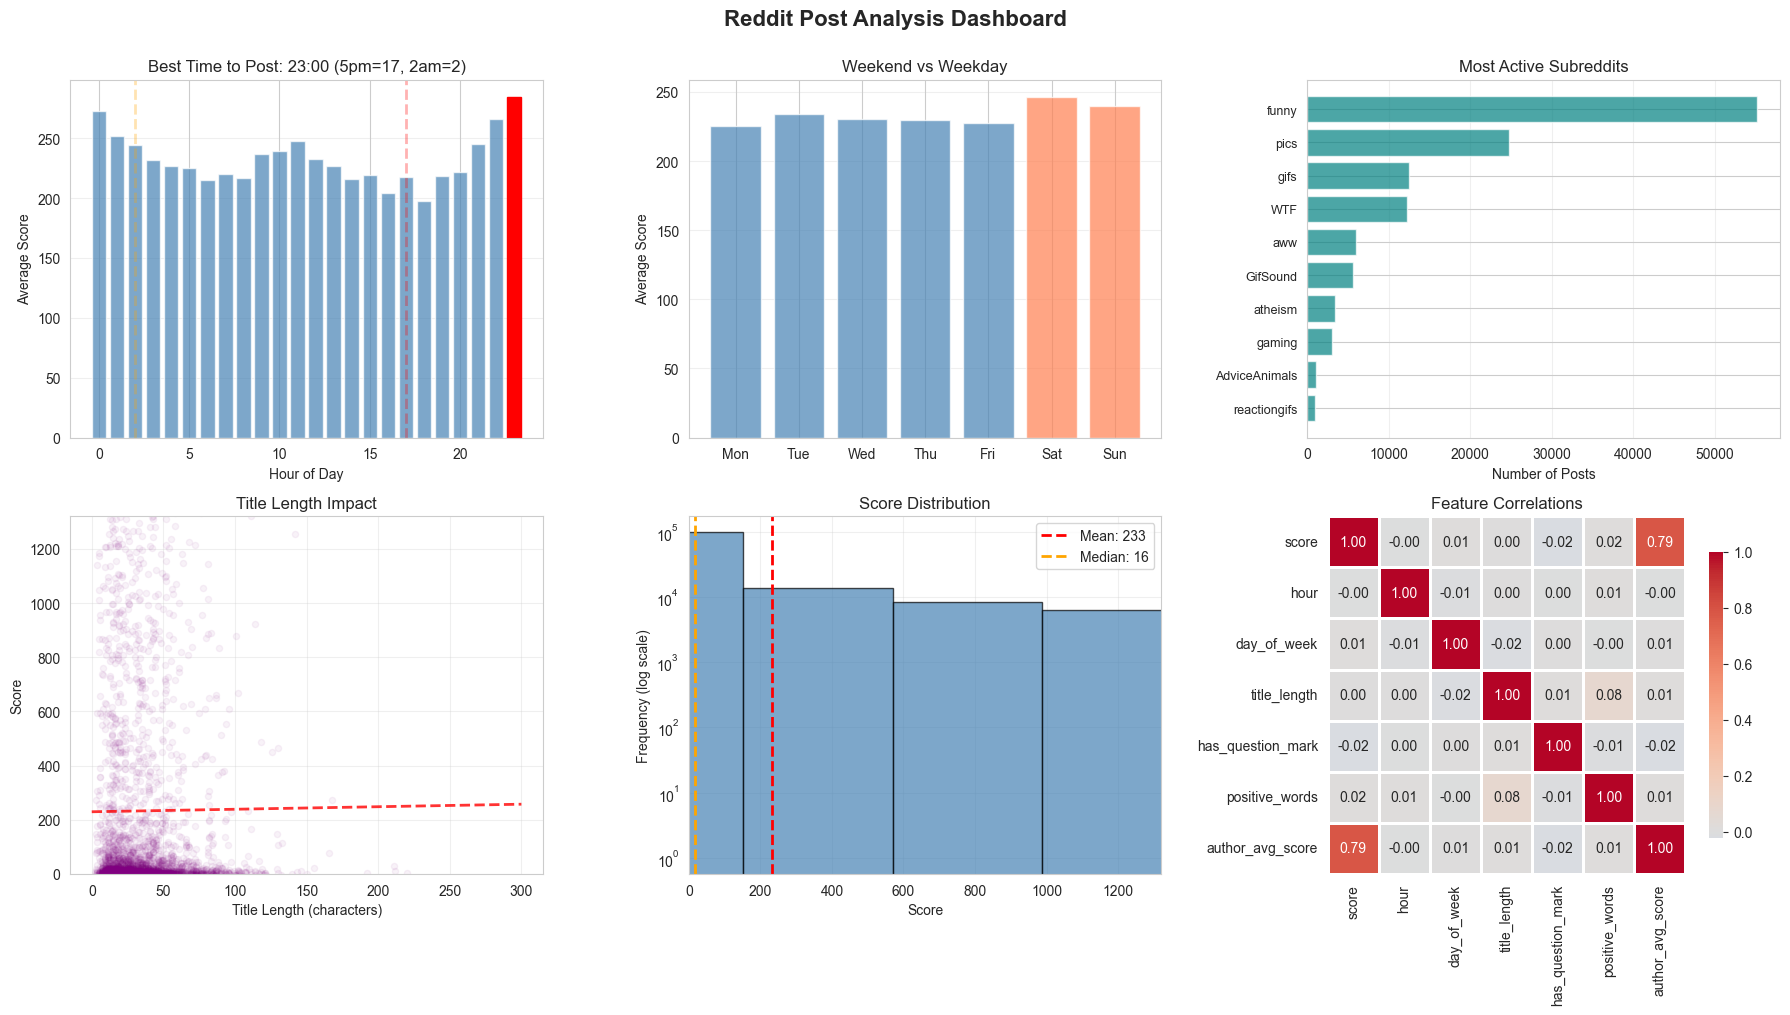


Key Findings:
- Best hour to post: 23:00
- Best day: Sat
- Average score: 233.1
- Median score: 16.0
- Title length correlation: 0.005


In [ ]:
## however many cells needed. Note the structure of the data.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("BenEDA/reddit_prepared.csv")
df["post_date"] = pd.to_datetime(df["post_date"])

# Set style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (15, 10)

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle("Reddit Post Analysis Dashboard", fontsize=16, fontweight="bold", y=1.00)

# 1. Best Hours to Post
ax1 = axes[0, 0]
hour_scores = df.groupby("hour")["score"].mean().sort_index()
bars = ax1.bar(hour_scores.index, hour_scores.values, color="steelblue", alpha=0.7)
max_hour = int(hour_scores.idxmax())
bars[max_hour].set_color("red")
bars[max_hour].set_alpha(1.0)
ax1.axvline(x=17, color="red", linestyle="--", alpha=0.3, linewidth=2)
ax1.axvline(x=2, color="orange", linestyle="--", alpha=0.3, linewidth=2)
ax1.set_xlabel("Hour of Day")
ax1.set_ylabel("Average Score")
ax1.set_title(f"Best Time to Post: {max_hour}:00 (5pm=17, 2am=2)")
ax1.grid(axis="y", alpha=0.3)

# 2. Day of Week Pattern
ax2 = axes[0, 1]
day_names = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
dow_scores = df.groupby("day_of_week")["score"].mean()
colors = ["steelblue"] * 5 + ["coral", "coral"]
ax2.bar(range(7), dow_scores.values, color=colors, alpha=0.7)
ax2.set_xticks(range(7))
ax2.set_xticklabels(day_names)
ax2.set_ylabel("Average Score")
ax2.set_title("Weekend vs Weekday")
ax2.grid(axis="y", alpha=0.3)

# 3. Top Subreddits
ax3 = axes[0, 2]
top_subs = df["subreddit"].value_counts().head(10)
ax3.barh(range(10), top_subs.values, color="teal", alpha=0.7)
ax3.set_yticks(range(10))
ax3.set_yticklabels(top_subs.index, fontsize=9)
ax3.set_xlabel("Number of Posts")
ax3.set_title("Most Active Subreddits")
ax3.invert_yaxis()
ax3.grid(axis="x", alpha=0.3)

# 4. Title Length vs Score
ax4 = axes[1, 0]
sample = df.sample(min(3000, len(df)))
ax4.scatter(sample["title_length"], sample["score"], alpha=0.05, s=20, color="purple")
ax4.set_xlabel("Title Length (characters)")
ax4.set_ylabel("Score")
ax4.set_title("Title Length Impact")
ax4.set_ylim(0, df["score"].quantile(0.95))
ax4.grid(alpha=0.3)

# Add trend line
z = np.polyfit(df["title_length"].dropna(), df["score"], 1)
p = np.poly1d(z)
x_trend = np.linspace(df["title_length"].min(), df["title_length"].max(), 100)
ax4.plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2)

# 5. Score Distribution
ax5 = axes[1, 1]
ax5.hist(df["score"], bins=50, color="steelblue", alpha=0.7, edgecolor="black")
ax5.axvline(
    df["score"].mean(),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Mean: {df['score'].mean():.0f}",
)
ax5.axvline(
    df["score"].median(),
    color="orange",
    linestyle="--",
    linewidth=2,
    label=f"Median: {df['score'].median():.0f}",
)
ax5.set_xlabel("Score")
ax5.set_ylabel("Frequency (log scale)")
ax5.set_title("Score Distribution")
ax5.set_xlim(0, df["score"].quantile(0.95))
ax5.set_yscale("log")
ax5.legend()
ax5.grid(alpha=0.3)

# 6. Correlation Heatmap (Top Features)
ax6 = axes[1, 2]
key_features = [
    "score",
    "hour",
    "day_of_week",
    "title_length",
    "has_question_mark",
    "positive_words",
    "author_avg_score",
]
corr_matrix = df[key_features].corr()
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=1,
    ax=ax6,
    cbar_kws={"shrink": 0.8},
)
ax6.set_title("Feature Correlations")

plt.tight_layout()
plt.show()

print("\nKey Findings:")
print(f"- Best hour to post: {max_hour}:00")
print(f"- Best day: {day_names[int(dow_scores.idxmax())]}")
print(f"- Average score: {df['score'].mean():.1f}")
print(f"- Median score: {df['score'].median():.1f}")
print(f"- Title length correlation: {df['title_length'].corr(df['score']):.3f}")


## 1. Data Validation

Before building any models, we first validate that the core numeric fields in the dataset are internally consistent and that there are no obvious data quality issues.

**Checks performed:**

1. **Score consistency**
   We verify that the Reddit `score` field matches the definition:
      `score` = `number_of_upvotes` - `number_of_downvotes`

2. **Non-negative votes**

   We confirm that `number_of_upvotes` and `number_of_downvotes` are never negative.  

3. **Duplicated posts**

   Using `reddit_id` as the unique identifier of a submission, we check for duplicated `reddit_id`s.  

4. **Missing values**

   Finally, we compute the total number of missing values in the dataset
      - The `username` column has 20,260 missing values, but will not be considered in our model
      - Every other column only has 1 missing value on the same row

In [ ]:
# Score = upvotes - downvotes
score_diff = (
    (df["number_of_upvotes"] - df["number_of_downvotes"] - df["score"]).abs().sum()
)
print("Score consistency check (should be 0):", score_diff)

# Non-negative votes

neg_votes = ((df["number_of_upvotes"] < 0) | (df["number_of_downvotes"] < 0)).sum()
print("Number of rows with negative votes (should be 0):", neg_votes)

dup_count = df["reddit_id"].duplicated().sum()
print("Number of duplicated reddit_id values:", dup_count)

# Missing Values
df_nan = df.isna().sum()
print(df_nan)


Score consistency check (should be 0): 0.0
Number of rows with negative votes (should be 0): 0
Number of duplicated reddit_id values: 93
#image_id                  0
unixtime                   1
rawtime                    1
title                      1
total_votes                1
reddit_id                  1
number_of_upvotes          1
subreddit                  1
number_of_downvotes        1
localtime                  1
score                      1
number_of_comments         1
username               20260
dtype: int64


# Data Cleaning

In [ ]:
# Casting
df["unixtime"] = pd.to_numeric(df["unixtime"], errors="coerce")
df["datetime"] = pd.to_datetime(df["unixtime"], unit="s")
df["total_votes"] = df["total_votes"].astype(float)
df["number_of_upvotes"] = df["number_of_upvotes"].astype(float)
df["number_of_downvotes"] = df["number_of_downvotes"].astype(float)
df["score"] = df["score"].astype(float)

# Duplicate Handling
df = df.drop_duplicates(subset=["reddit_id"])
dup_reddit_ids = df["reddit_id"].duplicated().sum()
print("Number of duplicated reddit_id values:", dup_reddit_ids)

# Missing Values Handling
df = df.drop(columns=["username"])
df = df.dropna()
print("Number of NANs:", df.isna().sum().sum())


def clean_title(text):
    # 1. Ensure string
    s = str(text)
    # 2. Unescape HTML entities: &quot; &amp; &lt; &gt; etc.
    s = html.unescape(s)
    # 3. Strip leading/trailing whitespace
    s = s.strip()
    # 4. Collapse multiple spaces/newlines into a single space
    s = re.sub(r"\s+", " ", s)
    # 5. (Optional) lowercase for modeling
    s = s.lower()
    return s


df["title_clean"] = df["title"].apply(clean_title)
df["title"] = df["title_clean"]
df.drop(columns=["title_clean"], inplace=True)

Number of duplicated reddit_id values: 0
Number of NANs: 0


## Because Reddit scores are extremely heavy-tailed, even after a log-transform the top 1–5% of posts still had disproportionate influence and caused numerically unstable predictions.

## We removed the top 5% of scores to make the distribution more well-behaved. After this, log-space MAE improved significantly and raw-space MAE became interpretable and stable.

In [ ]:
p95 = df["score"].quantile(0.95)
df = df[df["score"] <= p95].copy()


# this move massively improved our model

# i dont have a graph but i'm pretty sure the values towards the top are astronomically large

In [ ]:
print(df.shape)
df.head()

(125598, 13)


,#image_id,unixtime,rawtime,title,total_votes,reddit_id,number_of_upvotes,subreddit,number_of_downvotes,localtime,score,number_of_comments,datetime
1,0,1.333178e+09,2012-03-31T14:16:01.093638-07:00,expectation,35.0,rmun4,29.0,GifSound,6.0,1.333203e+09,23.0,3.0,2012-03-31 07:16:01
2,0,1.333200e+09,2012-03-31T20:18:33.192906-07:00,downvote,41.0,rna86,32.0,GifSound,9.0,1.333225e+09,23.0,0.0,2012-03-31 13:18:33
3,0,1.333252e+09,2012-04-01T10:52:10-07:00,every time i downvote something,10.0,ro7e4,6.0,GifSound,4.0,1.333278e+09,2.0,0.0,2012-04-01 03:52:10
4,0,1.333273e+09,2012-04-01T16:35:54.393381-07:00,"downvote ""dies irae""",65.0,rooof,57.0,GifSound,8.0,1.333298e+09,49.0,0.0,2012-04-01 09:35:54
5,0,1.333761e+09,2012-04-07T08:11:00-07:00,"demolished, every time you downvote someone",40.0,rxwjg,17.0,gifs,23.0,1.333786e+09,-6.0,3.0,2012-04-07 01:11:00


# Feature Engineering

In [ ]:
df["hour"] = df["datetime"].dt.hour
df["dayofweek"] = df["datetime"].dt.dayofweek
df["month"] = df["datetime"].dt.month
df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)

df["title"] = df["title"].astype(str).str.strip()
df["title_length"] = df["title"].apply(len)
df["word_count"] = df["title"].apply(lambda x: len(x.split()))
df["is_question"] = df["title"].str.contains("?", regex=False).astype(int)
df["is_exclamation"] = df["title"].str.contains("!", regex=False).astype(int)


# Adding subreddit stats - I did not include subreddit stats as I believe it leaks the target variable
# subreddit_stats = df.groupby('subreddit')['score'].agg(
#     subreddit_mean_score='mean',
#     subreddit_post_count='count'
# ).reset_index()
# df = df.merge(subreddit_stats, on='subreddit', how='left')

# Adding sentiment analysis
sia = SentimentIntensityAnalyzer()


def add_title_sentiment(df):
    titles = df["title"].astype(str)

    scores = titles.apply(sia.polarity_scores)
    scores_df = scores.apply(pd.Series)

    df["title_sent_neg"] = scores_df["neg"]
    df["title_sent_neu"] = scores_df["neu"]
    df["title_sent_pos"] = scores_df["pos"]
    df["title_sent_compound"] = scores_df["compound"]
    return df


# add new column
df = add_title_sentiment(df)

In [ ]:
df

,#image_id,unixtime,rawtime,title,total_votes,reddit_id,number_of_upvotes,subreddit,number_of_downvotes,localtime,...,month,is_weekend,title_length,word_count,is_question,is_exclamation,title_sent_neg,title_sent_neu,title_sent_pos,title_sent_compound
1,0,1.333178e+09,2012-03-31T14:16:01.093638-07:00,expectation,35.0,rmun4,29.0,GifSound,6.0,1.333203e+09,...,3,1,11,1,0,0,0.000,1.000,0.000,0.0000
2,0,1.333200e+09,2012-03-31T20:18:33.192906-07:00,downvote,41.0,rna86,32.0,GifSound,9.0,1.333225e+09,...,3,1,8,1,0,0,0.000,1.000,0.000,0.0000
3,0,1.333252e+09,2012-04-01T10:52:10-07:00,every time i downvote something,10.0,ro7e4,6.0,GifSound,4.0,1.333278e+09,...,4,1,31,5,0,0,0.000,1.000,0.000,0.0000
4,0,1.333273e+09,2012-04-01T16:35:54.393381-07:00,"downvote ""dies irae""",65.0,rooof,57.0,GifSound,8.0,1.333298e+09,...,4,1,20,3,0,0,0.000,1.000,0.000,0.0000
5,0,1.333761e+09,2012-04-07T08:11:00-07:00,"demolished, every time you downvote someone",40.0,rxwjg,17.0,gifs,23.0,1.333786e+09,...,4,1,43,6,0,0,0.000,1.000,0.000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132298,9998,1.344760e+09,2012-08-12T15:24:06-07:00,om nom nom,34.0,y41wv,25.0,funny,9.0,1.344785e+09,...,8,1,10,3,0,0,0.000,1.000,0.000,0.0000
132299,9998,1.345270e+09,2012-08-18T13:09:38-07:00,don't feed the animals...,19.0,yfw66,14.0,funny,5.0,1.345295e+09,...,8,1,25,4,0,0,0.000,1.000,0.000,0.0000
132300,9998,1.345954e+09,2012-08-26T04:06:02+00:00,wtf worthy.,49.0,yu838,26.0,WTF,23.0,1.345954e+09,...,8,1,11,2,0,0,0.567,0.000,0.433,-0.2263
132301,9998,1.346626e+09,2012-09-02T22:45:06+00:00,"just a camel eating a kids head, welcome to th...",123.0,z91ah,65.0,WTF,58.0,1.346626e+09,...,9,1,56,11,0,0,0.000,0.769,0.231,0.4588


# Modeling

### Setting up X,y for models

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# ----- 1. Define X and y -----

# Features
text_features = ["title"]
cat_features = ["subreddit"]
num_features = [
    "total_votes",
    "number_of_upvotes",
    "number_of_downvotes",
    "number_of_comments",
    "hour",
    "dayofweek",
    "month",
    "is_weekend",
    "title_length",
    "word_count",
    "is_question",
    "is_exclamation",
    "title_sent_neg",
    "title_sent_neu",
    "title_sent_pos",
    "title_sent_compound",
]

feature_cols = text_features + cat_features + num_features

X = df[feature_cols].copy()

# Target: use log(1 + score) to stabilize heavy tails
y_raw = df["score"]
min_score = y_raw.min()
# shift so that the minimum becomes 1, then log-transform
y_shifted = y_raw - min_score + 1
y_log = np.log(y_shifted)

# ----- 2. Train / test split: 80 / 20 -----

RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=RANDOM_STATE
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (100478, 18)
Test shape: (25120, 18)


## Baseline 1: Predict Global Mean

In [ ]:
from sklearn.metrics import mean_absolute_error

# 1. Baseline in log space
mean_pred = y_train.mean()
y_test_pred_log = np.full_like(y_test, mean_pred, dtype=float)

# 2. Inverse-transform both true and predicted values back to raw score
y_test_raw = np.exp(y_test) + min_score - 1
y_test_pred_raw = np.exp(y_test_pred_log) + min_score - 1

# 3. MAE in original score units (upvotes minus downvotes)
baseline_mae_raw = mean_absolute_error(y_test_raw, y_test_pred_raw)

print(f"Baseline MAE (log space): {mean_absolute_error(y_test, y_test_pred_log):.4f}")
print(f"Baseline MAE (raw score): {baseline_mae_raw:.4f}")


Baseline MAE (log space): 0.3695
Baseline MAE (raw score): 174.5136


## Baseline 2: Predict Subreddit Mean with Global Mean fallback

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ---- Baseline 2: Subreddit mean (with fallback to global mean) ----

# 1. Compute mean *log-score* per subreddit on TRAIN ONLY
train_df_for_means = pd.DataFrame(
    {
        "subreddit": X_train["subreddit"].values,
        "score_log": y_train,  # y_train is already log-transformed
    }
)

subreddit_means_log = train_df_for_means.groupby("subreddit")["score_log"].mean()

# Global mean in log space (used as fallback for unseen subreddits)
global_mean_log = y_train.mean()


def predict_subreddit_mean_log(X, subreddit_means_log, global_mean_log):
    """
    For each row in X, predict the mean *log-score* of its subreddit,
    falling back to the global mean (log) if the subreddit was unseen in training.
    """
    return X["subreddit"].map(subreddit_means_log).fillna(global_mean_log).values


# 2. Predictions on TEST set (log space)
y_test_pred_log = predict_subreddit_mean_log(
    X_test, subreddit_means_log, global_mean_log
)

# 3. Metrics in LOG space
mae_log = mean_absolute_error(y_test, y_test_pred_log)

# 4. Inverse transform both true and predicted back to RAW score space
# recall: y_log = log(score - min_score + 1)
y_test_raw = np.exp(y_test) + min_score - 1
y_test_pred_raw = np.exp(y_test_pred_log) + min_score - 1

mae_raw = mean_absolute_error(y_test_raw, y_test_pred_raw)

print(f"  Test MAE  (log):  {mae_log:.4f}")
print(f"  Test MAE  (raw):  {mae_raw:.4f}")


  Test MAE  (log):  0.3479
  Test MAE  (raw):  167.0088


## Linear Regression with TF-IDF + Metadata Featuers

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

RANDOM_STATE = 42  # for CV shuffling

lin_feature_cols = text_features + cat_features + num_features

X_train_lin = X_train[lin_feature_cols].copy()
X_test_lin = X_test[lin_feature_cols].copy()

text_col = "title"
cat_cols = cat_features
num_cols = num_features

preprocessor_lin = ColumnTransformer(
    transformers=[
        (
            "text",
            TfidfVectorizer(max_features=20000, ngram_range=(1, 2), min_df=5),
            text_col,
        ),
        (
            "cat",
            OneHotEncoder(handle_unknown="ignore"),
            cat_cols,
        ),
        (
            "num",
            StandardScaler(),
            num_cols,
        ),
    ]
)

lin_model = LinearRegression()

lin_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor_lin),
        ("model", lin_model),
    ]
)

# 5 fold CV for consistency
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_scores = cross_val_score(
    lin_pipeline,
    X_train_lin,
    y_train,
    cv=cv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
)


lin_pipeline.fit(X_train_lin, y_train)

# Predictions in log space
y_test_pred_log_lin = lin_pipeline.predict(X_test_lin)

# Log-space metrics
lin_mae_log = mean_absolute_error(y_test, y_test_pred_log_lin)

# Inverse-transform back to raw score space
y_test_raw = np.exp(y_test) + min_score - 1
y_test_pred_raw_lin = np.exp(y_test_pred_log_lin) + min_score - 1

lin_mae_raw = mean_absolute_error(y_test_raw, y_test_pred_raw_lin)

print(f"  Test MAE  (log): {lin_mae_log:.4f}")
print(f"  Test MAE  (raw): {lin_mae_raw:.4f}")


  Test MAE  (log): 0.0766
  Test MAE  (raw): 43.0519


## Champion Model: Ridge Regression with TF-IDF + Metadata Features

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error

ridge_feature_cols = text_features + cat_features + num_features

X_train_ridge = X_train[ridge_feature_cols].copy()
X_test_ridge = X_test[ridge_feature_cols].copy()


text_col = "title"
cat_cols = cat_features
num_cols = num_features

preprocessor = ColumnTransformer(
    transformers=[
        (
            "text",
            TfidfVectorizer(max_features=20000, ngram_range=(1, 2), min_df=5),
            text_col,
        ),
        (
            "cat",
            OneHotEncoder(handle_unknown="ignore"),
            cat_cols,
        ),
        (
            "num",
            StandardScaler(),
            num_cols,
        ),
    ]
)

# 5 fold CV
base_ridge = Ridge(random_state=RANDOM_STATE)

ridge_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", base_ridge),
    ]
)

param_grid = {"model__alpha": [0.01, 0.1, 1, 3, 10, 30, 100]}

grid = GridSearchCV(
    estimator=ridge_pipeline,
    param_grid=param_grid,
    scoring="neg_mean_absolute_error",  #!!!! MAE in LOG space
    cv=5,
    n_jobs=-1,
    verbose=1,
)

# y_train is log-transformed already!!!!! dont forget
grid.fit(X_train_ridge, y_train)


best_ridge = grid.best_estimator_

# Predict in log(shifted score) space
y_test_pred_log = best_ridge.predict(X_test_ridge)
# Metrics in LOG space
mae_log = mean_absolute_error(y_test, y_test_pred_log)

y_test_pred_log = best_ridge.predict(X_test_ridge)
# log metrics
mae_log = mean_absolute_error(y_test, y_test_pred_log)
# back to raw
y_test_raw = np.exp(y_test) + min_score - 1
y_test_pred_raw = np.exp(y_test_pred_log) + min_score - 1
mae_raw = mean_absolute_error(y_test_raw, y_test_pred_raw)
print("Ridge MAE (log):", mae_log)
print("Ridge MAE (raw):", mae_raw)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Ridge MAE (log): 0.06883936243843784
Ridge MAE (raw): 40.03342035932269


### Argument and Defense for Ridge:

1. Theoretically most appropritate model
    - Given that this is very high dimensional with TF-IDF features, this would not be a tree based problem (Random Forest, XGBoost)

2. I guess academically most academically appropriate model, its standard in ML 

3. Better preformance compared to linear regresion
